In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import os

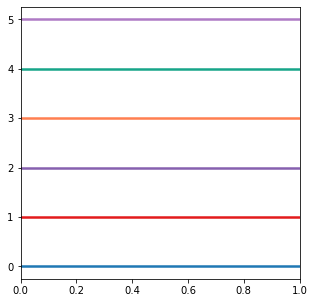

In [2]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

new_cmap = [ '#1F78B4', '#E31A1C', '#8660AF', '#FF7F50', '#17A589', '#AF7AC5']
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,6))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [3]:
oligomersizes = np.arange(2, 61, 2)
nr_frames_out = 15001
MATH_type = 'MATHfree'

In [4]:
os.system('mkdir figures/highree_subsample')

mkdir: cannot create directory ‘figures/highree_subsample’: File exists


256

In [5]:
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

In [6]:
#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)

#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

#Calculate concentrations with isodesmic model
#Returns array of oligomer concentrations
def isodesmic(Ka, Ctot, oligomersizes):
    
    BTBdimer_conc = Ctot/2.0
    
    C = []
    
    #Calculate monomer concentration
    conc = (2*BTBdimer_conc*Ka+1-np.sqrt(4*BTBdimer_conc*Ka+1))/(2*BTBdimer_conc*(Ka**2))
    C.append(conc)
    
    #Calculate oligomer concentrations
    for i in range(1,len(oligomersizes)):
        conc = Ka*C[i-1]*C[0]
        C.append(conc)
        
    return np.array(C)

def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value


In [7]:
sel_frames_vs_size = []
sel_frames_all_vs_size = []

for size in oligomersizes:
        
    ree = load_pickle(f'pickles/{MATH_type}/e2e_dist_{size}mer.pkl')
    ree_avg = np.average(ree)
    ree_max = np.amax(ree)
    
    ree_cutoff = ree_max - ((ree_max-ree_avg)/2)
    
    acceptable_frames = np.nonzero(ree > ree_cutoff)[0]
    print(f'{size}mer has {len(acceptable_frames)} frames that work')
    
    sel_frames = np.random.choice(acceptable_frames, nr_frames_out)
    sel_frames_vs_size.append(sel_frames)

2mer has 339 frames that work
4mer has 567 frames that work
6mer has 757 frames that work
8mer has 479 frames that work
10mer has 599 frames that work
12mer has 640 frames that work
14mer has 632 frames that work
16mer has 557 frames that work
18mer has 806 frames that work
20mer has 669 frames that work
22mer has 461 frames that work
24mer has 475 frames that work
26mer has 644 frames that work
28mer has 324 frames that work
30mer has 736 frames that work
32mer has 388 frames that work
34mer has 543 frames that work
36mer has 642 frames that work
38mer has 453 frames that work
40mer has 547 frames that work
42mer has 558 frames that work
44mer has 193 frames that work
46mer has 445 frames that work
48mer has 418 frames that work
50mer has 459 frames that work
52mer has 483 frames that work
54mer has 601 frames that work
56mer has 567 frames that work
58mer has 557 frames that work
60mer has 418 frames that work


# Plot subsampled r_ee distances

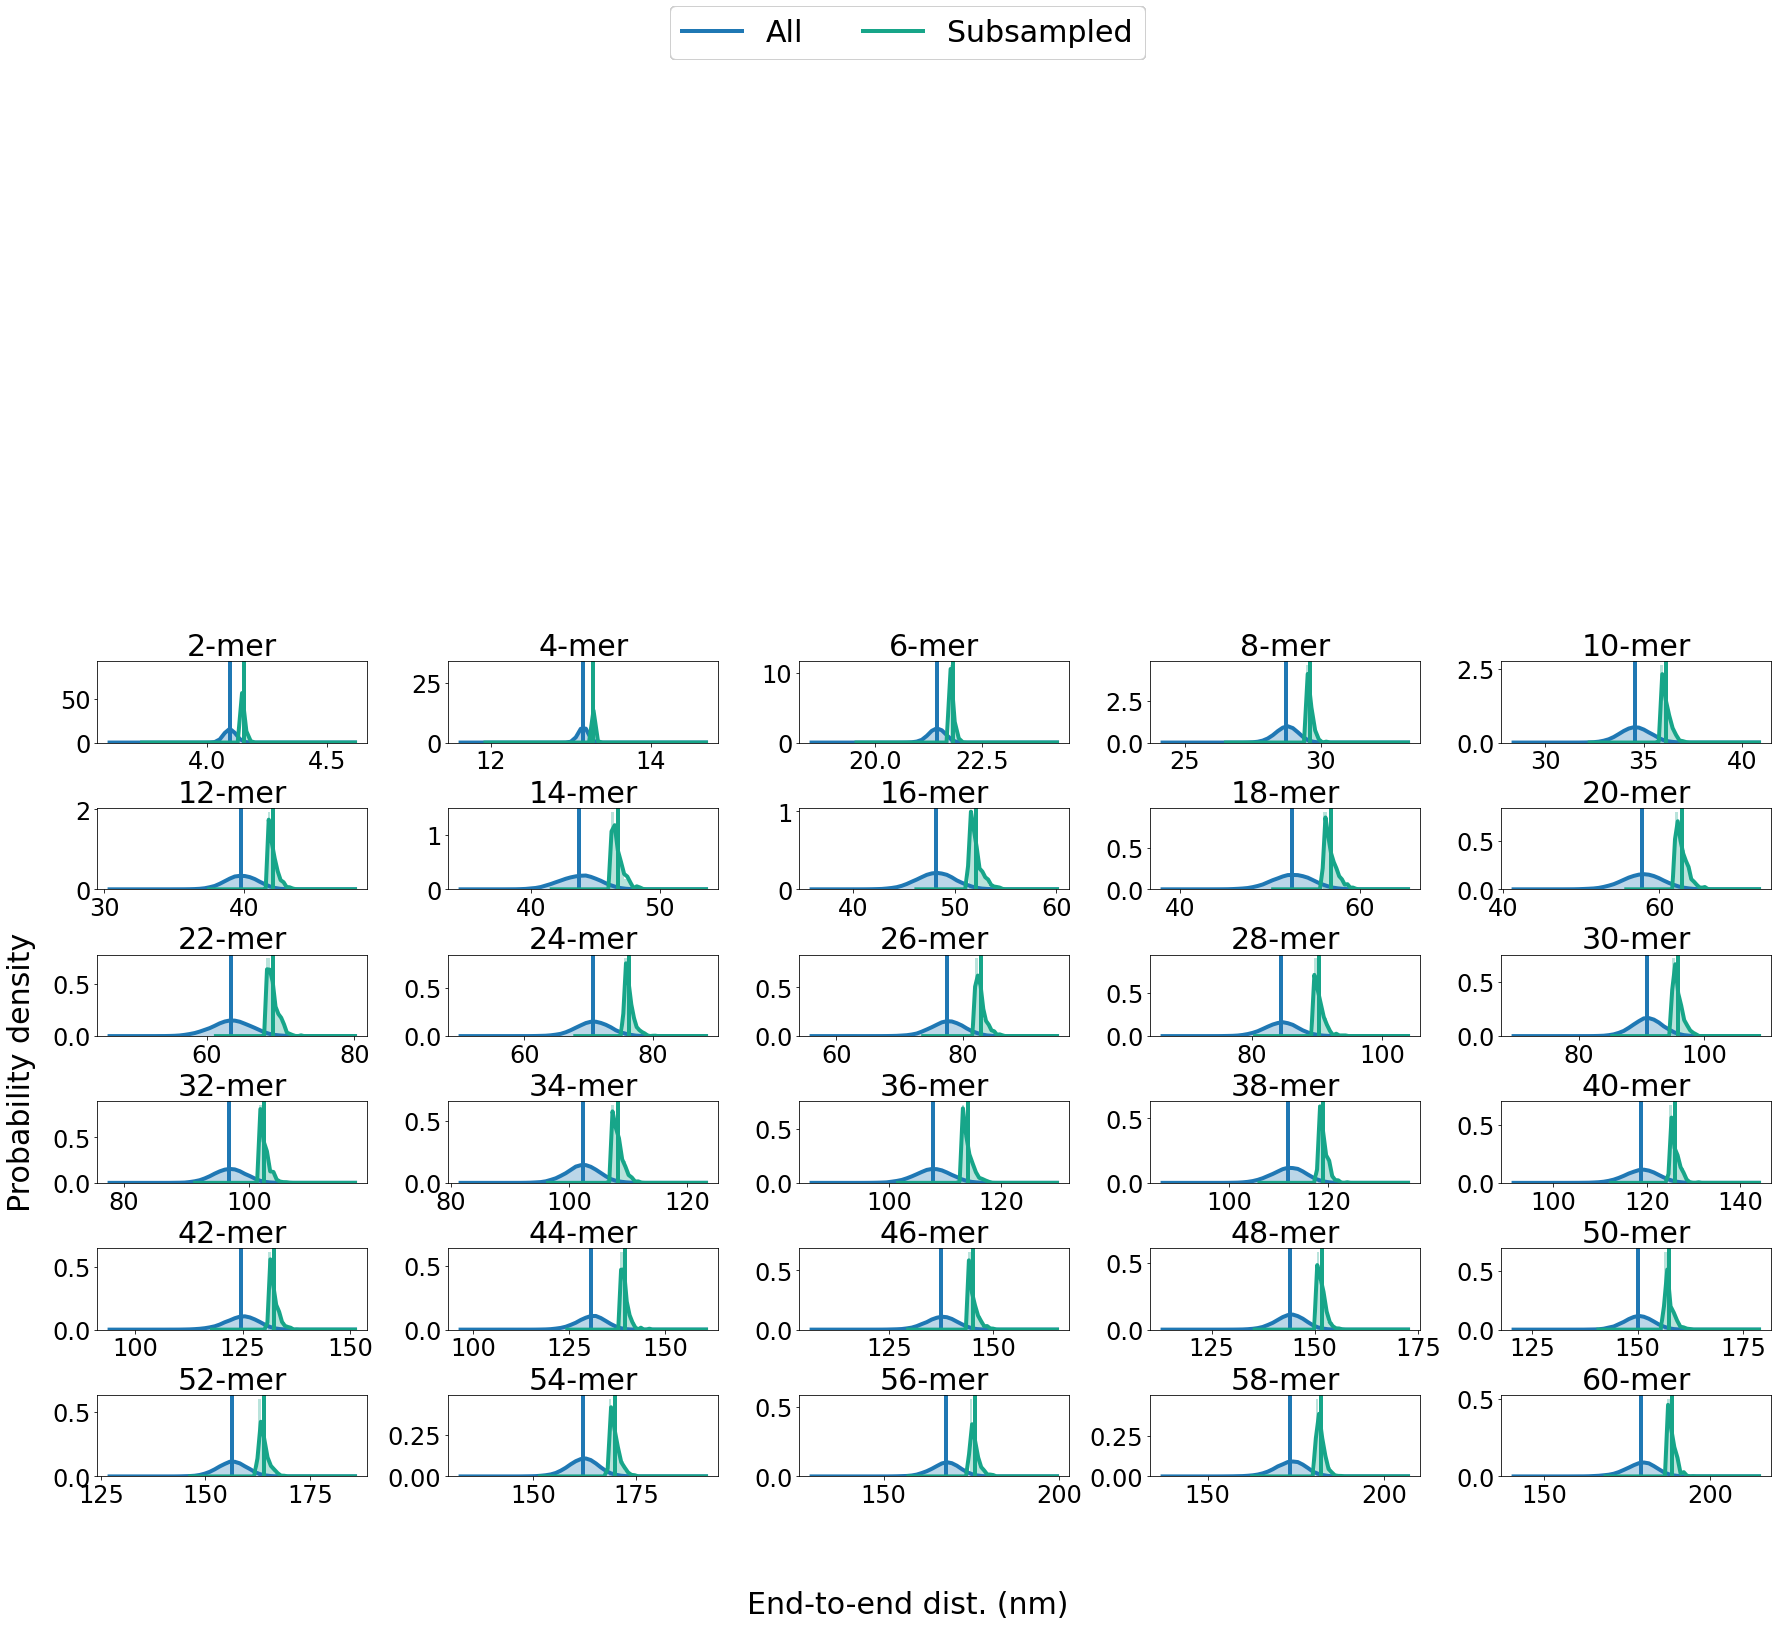

In [8]:
#Start plot
fig, ax = plt.subplots(figsize=(30,15), nrows=6, ncols=5)    
plt.subplots_adjust(hspace = 0.8, wspace=0.3)
fig.text(0.5, 0.02, 'End-to-end dist. (nm)', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.5, 'Probability density', ha='center', va='center', fontsize=30, rotation=90)

k=0
n=0
for i,size in enumerate(oligomersizes):
    
    ree = load_pickle(f'pickles/{MATH_type}/e2e_dist_{size}mer.pkl')
    ree_subsampled = ree[sel_frames_vs_size[i]]
    
    #Plot title
    ax[k,n].set_title(f'{size}-mer', fontsize=30)
    
    #KDE
    kde_x = np.linspace( np.amin(ree)*0.9, np.amax(ree)*1.1, num = 50 )
    kde_y = stats.gaussian_kde(ree, bw_method = "silverman").evaluate(kde_x)
    
    #Plot
    ax[k,n].hist(ree, density=True, color=colors[0], alpha=0.3, bins=30)
    ax[k,n].plot(kde_x, kde_y, '-', linewidth=4, color=colors[0])
    if k==0 and n==0:
        ax[k,n].axvline(np.average(ree),linewidth=4, alpha=1, color=colors[0], label='All')
    else:
        ax[k,n].axvline(np.average(ree),linewidth=4, alpha=1, color=colors[0])

    #KDE
    kde_x = np.linspace( np.amin(ree_subsampled)*0.9, np.amax(ree_subsampled)*1.1, num = 50 )
    kde_y = stats.gaussian_kde(ree_subsampled, bw_method = "silverman").evaluate(kde_x)
    
    #Plot
    ax[k,n].hist(ree_subsampled, density=True, color=colors[4], alpha=0.3, bins=10)
    ax[k,n].plot(kde_x, kde_y, '-', linewidth=4, color=colors[4])
    if k==0 and n==0:
        ax[k,n].axvline(np.average(ree_subsampled),linewidth=4, alpha=1, color=colors[4], label='Subsampled')
    else:
        ax[k,n].axvline(np.average(ree_subsampled),linewidth=4, alpha=1, color=colors[4])
    ax[k,n].tick_params(axis='both', which='major', labelsize=24)
    
    #Iterate over plot panel indeces
    n+=1
    if n==5:
        n=0
        k+=1

    #Add legend
    fig.legend(fontsize=30, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

#Save
fig.savefig(f"figures/highree_subsample/ree_distributions.pdf", bbox_inches='tight', pad_inches=1)


# Plot subsampled Rg distributions

IOStream.flush timed out


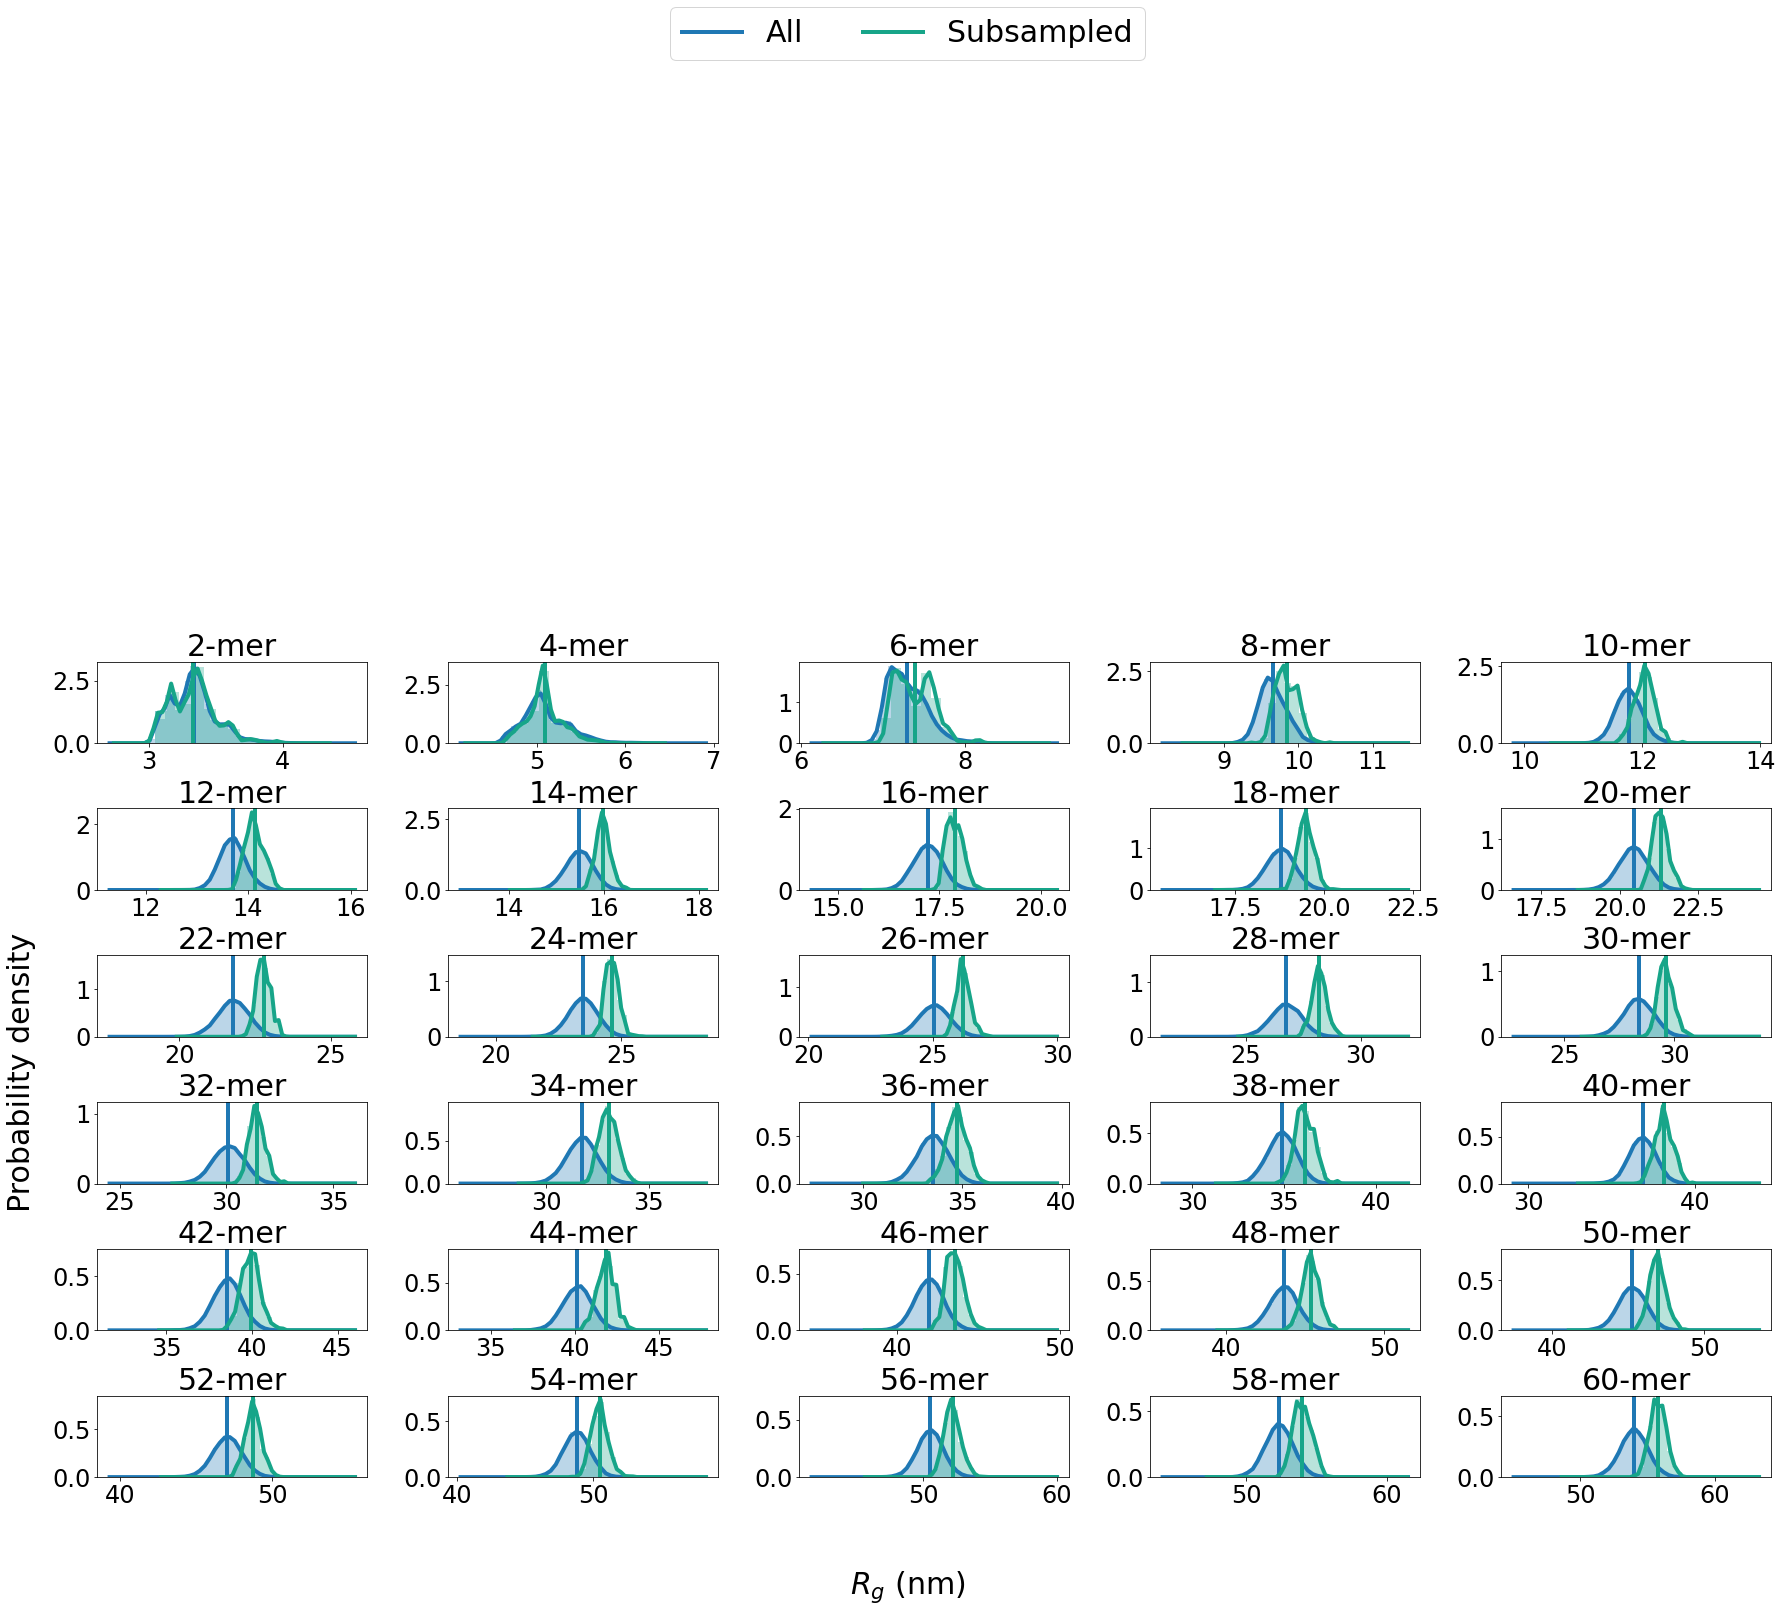

In [9]:
#Start plot
fig, ax = plt.subplots(figsize=(30,15), nrows=6, ncols=5)    
plt.subplots_adjust(hspace = 0.8, wspace=0.3)
fig.text(0.5, 0.04, '$R_g$ (nm)', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.5, 'Probability density', ha='center', va='center', fontsize=30, rotation=90)

k=0
n=0
for i,size in enumerate(oligomersizes):
    
    #Get Rg from file
    time, Rg = np.genfromtxt(f'MATHfree_runs/SPOP_{size}mer/Rg_gyrate_AA.xvg', usecols=(0,1), skip_header=27, unpack=True)
    Rg_subsampled = Rg[sel_frames_vs_size[i]] 
    
    #Plot title
    ax[k,n].set_title(f'{size}-mer', fontsize=30)
    
    #KDE
    kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 50 )
    kde_y = stats.gaussian_kde(Rg, bw_method = "silverman").evaluate(kde_x)
    
    #Plot
    ax[k,n].hist(Rg, density=True, color=colors[0], alpha=0.3, bins=30)
    ax[k,n].plot(kde_x, kde_y, '-', linewidth=4, color=colors[0])
    if k==0 and n==0:
        ax[k,n].axvline(np.average(Rg),linewidth=4, alpha=1, color=colors[0], label='All')
    else:
        ax[k,n].axvline(np.average(Rg),linewidth=4, alpha=1, color=colors[0])

    #KDE
    kde_x = np.linspace( np.amin(Rg_subsampled)*0.9, np.amax(Rg_subsampled)*1.1, num = 50 )
    kde_y = stats.gaussian_kde(Rg_subsampled, bw_method = "silverman").evaluate(kde_x)
    
    #Plot
    ax[k,n].hist(Rg_subsampled, density=True, color=colors[4], alpha=0.3, bins=10)
    ax[k,n].plot(kde_x, kde_y, '-', linewidth=4, color=colors[4])
    if k==0 and n==0:
        ax[k,n].axvline(np.average(Rg_subsampled),linewidth=4, alpha=1, color=colors[4], label='Subsampled')
    else:
        ax[k,n].axvline(np.average(Rg_subsampled),linewidth=4, alpha=1, color=colors[4])
    
    ax[k,n].tick_params(axis='both', which='major', labelsize=24)
    
    #Iterate over plot panel indeces
    n+=1
    if n==5:
        n=0
        k+=1

#Add legend
fig.legend(fontsize=30, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

#Save
fig.savefig(f"figures/highree_subsample/rg_distributions.pdf", bbox_inches='tight', pad_inches=1)


# SAXS with CG-MALS Kd

In [10]:
concs = [5.0, 10.0, 20.0, 30.0, 40.0]
Ka = 0.625
calcpath='../Reweighting_pipeline/calc_data_MATHfree'

In [11]:
#Make array of simulation SAXS data
calc_data = []
calc_data_subsampled = []

for i,oligomersize in enumerate(oligomersizes):
    simSAXS = load_sim_SAXS(f'{calcpath}/calc_data_{oligomersize}mer.dat')

    calc_data.append(simSAXS)
    
    simSAXS_subsampled = simSAXS[sel_frames_vs_size[i]]
    calc_data_subsampled.append(simSAXS_subsampled)
    
calc_data = np.array(calc_data)
calc_data_subsampled = np.array(calc_data_subsampled)

In [12]:
#Get experimental SAXS
Iexp_vs_concs = []
err_exp_vs_concs = []
for conc in concs:
    exp_file = f'../Reweighting_pipeline/WT_MATHfree_scaleoffsetonly/exp_data_{conc}uM.dat'
    q, Iexp, err_exp = load_exp_SAXS(exp_file)
    Iexp_vs_concs.append(Iexp)
    err_exp_vs_concs.append(err_exp)

Chi2_global for all: 1.5343662373320872
Chi2_global for subsampled: 1.5379906179874225


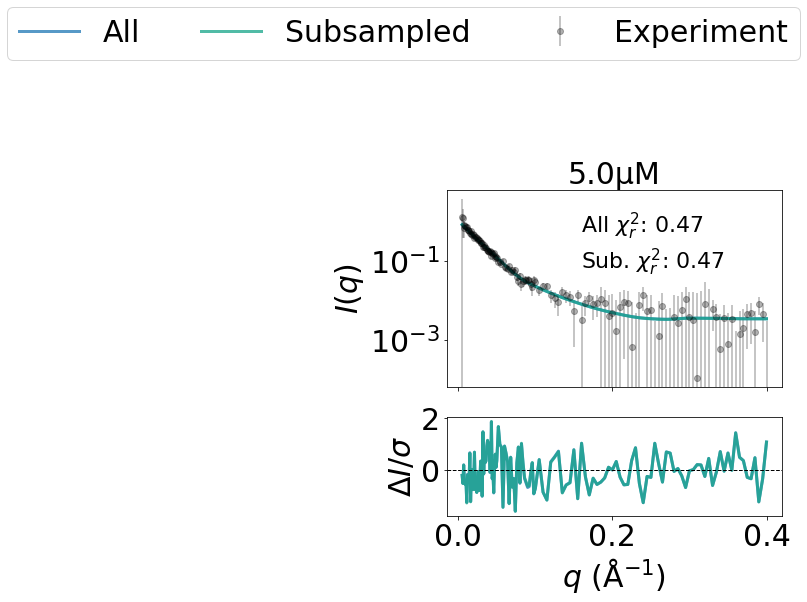

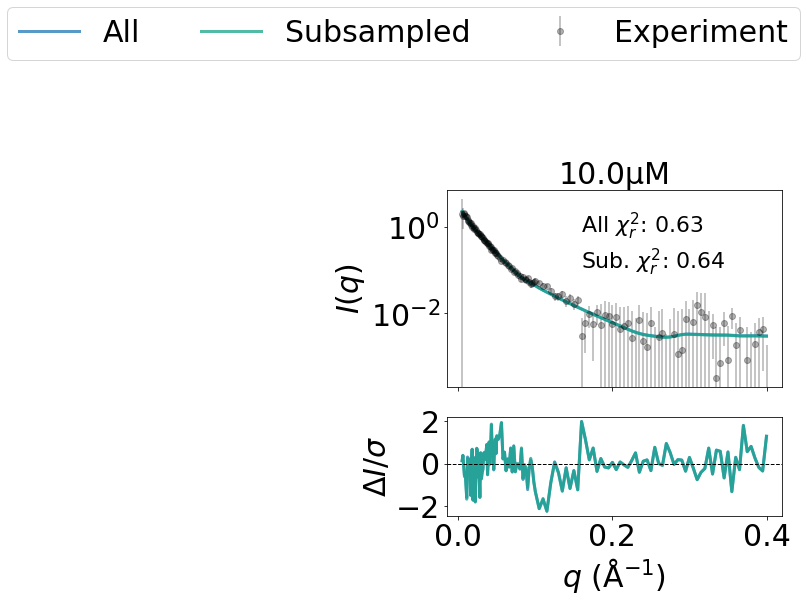

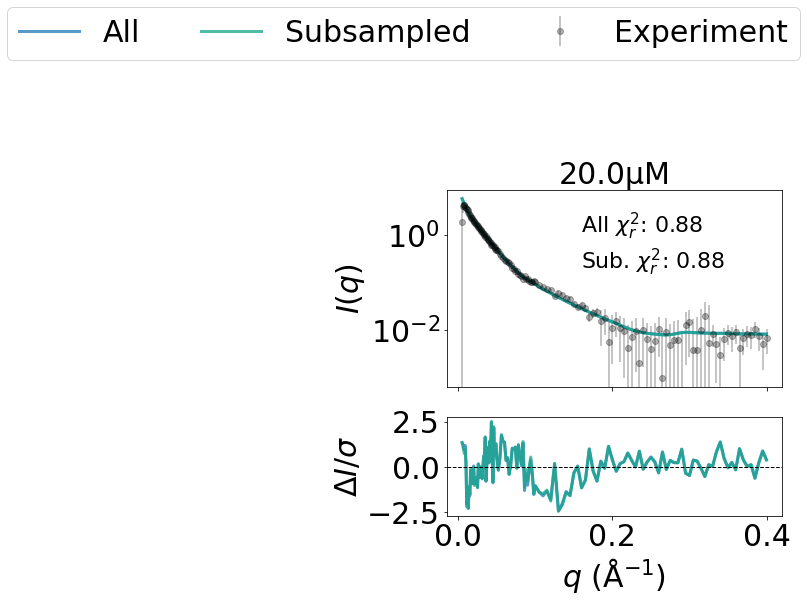

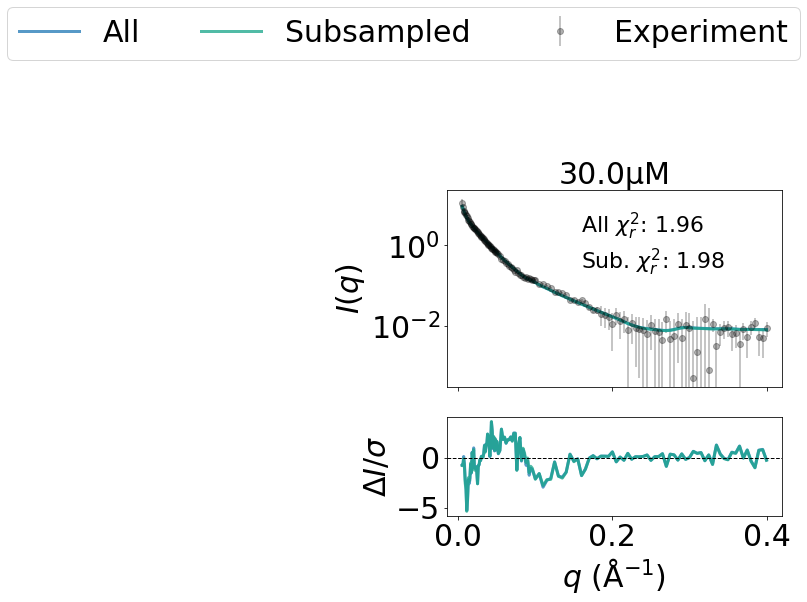

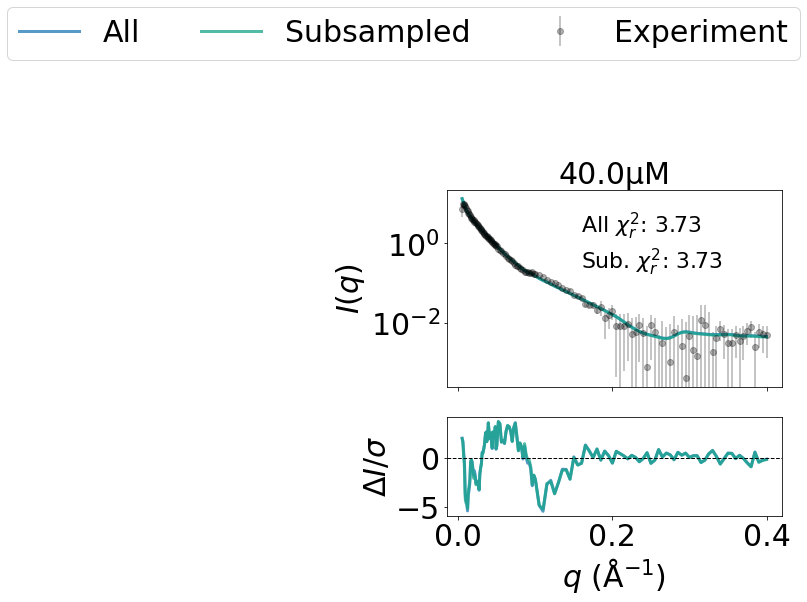

In [13]:
#All SAXS
Iaverage_vs_size = np.average(calc_data, axis=1)
#Subsampled SAXS
Iaverage_vs_size_subsampled = np.average(calc_data_subsampled, axis=1)

chi2_global = 0
chi2_global_subsampled = 0
for i,conc in enumerate(concs):
    
    #All SAXS

    #Get concentrations from isodesmic model
    isodesmic_concs = isodesmic(Ka, conc, oligomersizes)
    volume_weights = isodesmic_concs*oligomersizes
    volume_weights = volume_weights/np.sum(volume_weights)

    #Calculate average SAXS
    Iaverage = np.sum(Iaverage_vs_size*volume_weights[:,np.newaxis],axis=0)

    #Fit SAXS scale and cst
    Iaverage_fit, slope, intercept, r_value = fit_scale_offset(Iaverage, Iexp_vs_concs[i], err_exp_vs_concs[i])

    #Calculate chi2 and add to running sum
    chi2 = get_chi2(Iaverage_fit, Iexp_vs_concs[i], err_exp_vs_concs[i])
    chi2_global += chi2

    residuals = (Iaverage_fit - Iexp_vs_concs[i])/err_exp_vs_concs[i]

    
    #Subsampled SAXS

    #Calculate average SAXS
    Iaverage = np.sum(Iaverage_vs_size_subsampled*volume_weights[:,np.newaxis],axis=0)

    #Fit SAXS scale and cst
    Iaverage_fit_subsampled, slope, intercept, r_value = fit_scale_offset(Iaverage, Iexp_vs_concs[i], err_exp_vs_concs[i])

    #Calculate chi2 and add to running sum
    chi2_subsampled = get_chi2(Iaverage_fit_subsampled, Iexp_vs_concs[i], err_exp_vs_concs[i])
    chi2_global_subsampled += chi2_subsampled

    residuals_subsampled = (Iaverage_fit_subsampled - Iexp_vs_concs[i])/err_exp_vs_concs[i]
    
    #Plot SAXS data
    #SAXS figure
    fig, ax = plt.subplots(figsize = (6,6), nrows=2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [4, 2]})

    ax[0].set_title(f'{conc}µM', fontsize=30)

    ax[0].errorbar(q, Iexp_vs_concs[i], yerr=err_exp_vs_concs[i], fmt='o', markersize=6, color='black', alpha=0.3, label='Experiment')
    ax[0].plot(q, Iaverage_fit, linewidth=3, label="All", alpha=0.75, color=colors[0])
    ax[0].plot(q, Iaverage_fit_subsampled, linewidth=3, label="Subsampled", alpha=0.75, color=colors[4])

    ax[0].semilogy()
    ax[0].set_ylabel('$I(q)$', fontsize=30)
    ax[0].legend(fontsize=30, ncol=6, bbox_to_anchor=(1.1, 2.0))
    ax[0].text(0.40,0.60, f'All $χ^2_r$: {chi2:.2f} \nSub. $χ^2_r$: {chi2_subsampled:.2f}', fontsize=22, transform=ax[0].transAxes)

    for j in range(len(ax)):
        ax[j].tick_params(axis='both', which='major', labelsize=30)

    ax[1].plot(q, residuals, linewidth=3, color= colors[0], alpha=0.75)
    ax[1].plot(q, residuals_subsampled, linewidth=3, color= colors[4], alpha=0.75)

    ax[1].set_ylabel('$ΔI/σ$', fontsize=30)
    ax[1].set_xlabel('$q$ (Å$^{-1}$)', fontsize=30)
    ax[1].axhline(0, ls='--', linewidth=1, color='black')

    fig.savefig(f"figures/highree_subsample/SAXS_{conc}uM_Ka{Ka}.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
    
chi2_global /= len(concs)
chi2_global_subsampled /= len(concs)

print(f'Chi2_global for all: {chi2_global}')
print(f'Chi2_global for subsampled: {chi2_global_subsampled}')